In [1]:
import keras # расскоментируйте эту строку, чтобы начать обучение
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
# установка параметров нейросети
batch_size = 50
num_classes = 100
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar100_trained_model.h5'

In [3]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print("{1} train samples, {2} channel{0}, {3}x{4}".format("" if x_train.shape[1] == 1 else "s", *x_train.shape))
print("{1}  test samples, {2} channel{0}, {3}x{4}".format("" if x_test.shape[1] == 1 else "s", *x_test.shape))

50000 train samples, 32 channels, 32x3
10000  test samples, 32 channels, 32x3


In [4]:
# преобразование матрицы чисел 0-100 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [6]:
# инициализация RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=0, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Использование data augmentation в реальном времени
Epoch 1/10
1000/1000 [==============================] - 27s 27ms/step - loss: 4.1926 - accuracy: 0.0674 - val_loss: 3.6574 - val_accuracy: 0.1578
Epoch 2/10
1000/1000 [==============================] - 25s 25ms/step - loss: 3.7286 - accuracy: 0.1303 - val_loss: 3.3057 - val_accuracy: 0.2178
Epoch 3/10
1000/1000 [==============================] - 25s 25ms/step - loss: 3.4418 - accuracy: 0.1784 - val_loss: 3.0242 - val_accuracy: 0.2701
Epoch 4/10
1000/1000 [==============================] - 25s 25ms/step - loss: 3.2288 - accuracy: 0.2166 - val_loss: 2.8758 - val_accuracy: 0.2942
Epoch 5/10
1000/1000 [==============================] - 25s 25ms/step - loss: 3.0855 - accuracy: 0.2427 - val_loss: 2.6720 - val_accuracy: 0.3330
Epoch 6/10
1000/1000 [==============================] - 25s 25ms/step - loss: 2.9630 - accuracy: 0.2676 - val_loss: 2.5729 - val_accuracy: 0.3561
Epoch 7/10
1000/1000 [==============================] - 25s 25ms/step - l

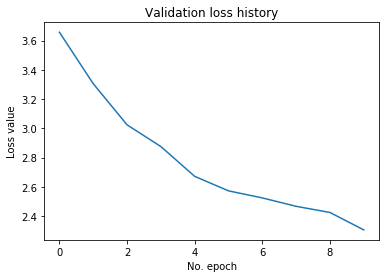

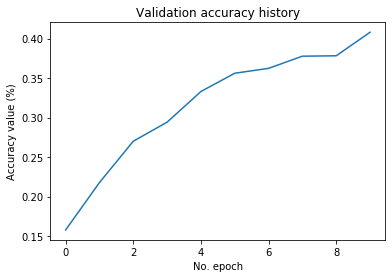

In [7]:
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()